In [1]:
# Import dependencies
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [72]:
df = pd.read_csv('adult.csv')

In [73]:
df.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


In [74]:
# Label Encoding
le_workclass = LabelEncoder()
le_education = LabelEncoder()
le_marital_status = LabelEncoder()
le_occupation = LabelEncoder()
le_relationship = LabelEncoder()
le_race = LabelEncoder()
le_sex = LabelEncoder()
le_native_country = LabelEncoder()
le_income = LabelEncoder()

df['workclass'] = le_workclass.fit_transform(df['workclass'])
df['education'] = le_education.fit_transform(df['education'])
df['marital.status'] = le_marital_status.fit_transform(df['marital.status'])
df['occupation'] = le_occupation.fit_transform(df['occupation'])
df['relationship'] = le_relationship.fit_transform(df['relationship'])
df['race'] = le_race.fit_transform(df['race'])
df['sex'] = le_sex.fit_transform(df['sex'])
df['native.country'] = le_native_country.fit_transform(df['native.country'])
df['income'] = le_income.fit_transform(df['income'])

In [75]:
class SyntheticForest:
    def __init__(self, classifier, regressor):
        """Multivariate imputer that estimates each feature from all the others.
        A strategy for imputing missing values by modeling each feature with
        missing values as a function of other features in a round-robin fashion.
        Read more in the :ref:`User Guide <iterative_imputer>`.

        Parameters
        ----------
        classifier : estimator object
            The estimator to use at each step of the round-robin imputation.
        
        regressor : estimator object
            The estimator to use at each step of the round-robin imputation.
        """
        self.classifier = classifier
        self.regressor = regressor
    
    def fit(self, train, categorical_variables=None):
        """
        Parameters
        ----------
        train : ndarray
            Input data with the most recent imputations.
        categorical_variables : str, list or tuple, default=None
            The string or list to help SyntheticForest to match
            appropriate estimators for features.
        """
        self.train = train
        self.train.index = range(len(train))
        self.categorical_variables = categorical_variables
        
        if ~isinstance(categorical_variables, list) or ~isinstance(categorical_variables, tuple):
            categorical_variables = [categorical_variables]
            
        syn_output_continous = []
        syn_output_discrete = []
        for c in train.columns:
            if c not in categorical_variables:
                e = self.regressor

            else:
                e = self.classifier

            X_train_syn = train.drop(c, axis=1)
            y_train_syn = train[c]
            e.fit(X_train_syn, y_train_syn)
            y_pred = e.predict(X_train_syn)

            if c not in categorical_variables:
                syn_output_continous.append(y_pred)

            else:
                syn_output_discrete.append(y_pred)
        
        final_gen = pd.DataFrame(np.vstack(syn_output_continous + syn_output_discrete), index=train.columns).T
        self.final_gen = final_gen
    
    def transform(self, n_dilution=2):
        """
        Parameters
        ----------
        n_dilution : int, default=2
            Maximum number of dilution rounds to perform before returning the
            synthetic data during the final round. A round is a single
            dilution which calculate the mean of the synthesised data and the 
            input data, to achieve a more realistic outcome.
        """
        final_gen = self.final_gen
        train = self.train
        categorical_variables = self.categorical_variables
        
        continous_cols = final_gen.drop(categorical_variables, axis=1).columns
        for _ in range(n_dilution):
            final_gen[continous_cols] = (train[continous_cols] + final_gen[continous_cols]) / 2
            
            
            N1 = int(len(final_gen) / 2)
            N2 = len(final_gen) - N1
            final_gen[categorical_variables] = pd.concat([
                final_gen[categorical_variables].sample(n=N1), 
                train[categorical_variables].sample(n=N2)
            ]).to_numpy()
        
        return final_gen

In [76]:
# Initiate Synthetic Forest instance
ts = SyntheticForest(
    classifier=XGBClassifier(n_jobs=-1, use_label_encoder=False), 
    regressor=XGBRegressor(n_jobs=-1, use_label_encoder=False)
)

# Fit our toy dataset into it
ts.fit(df, categorical_variables=['workclass', 'education', 'marital.status', 'occupation', 'relationship', 'race', 'sex', 'native.country', 'income'])
syn = ts.transform(2)

C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-pack

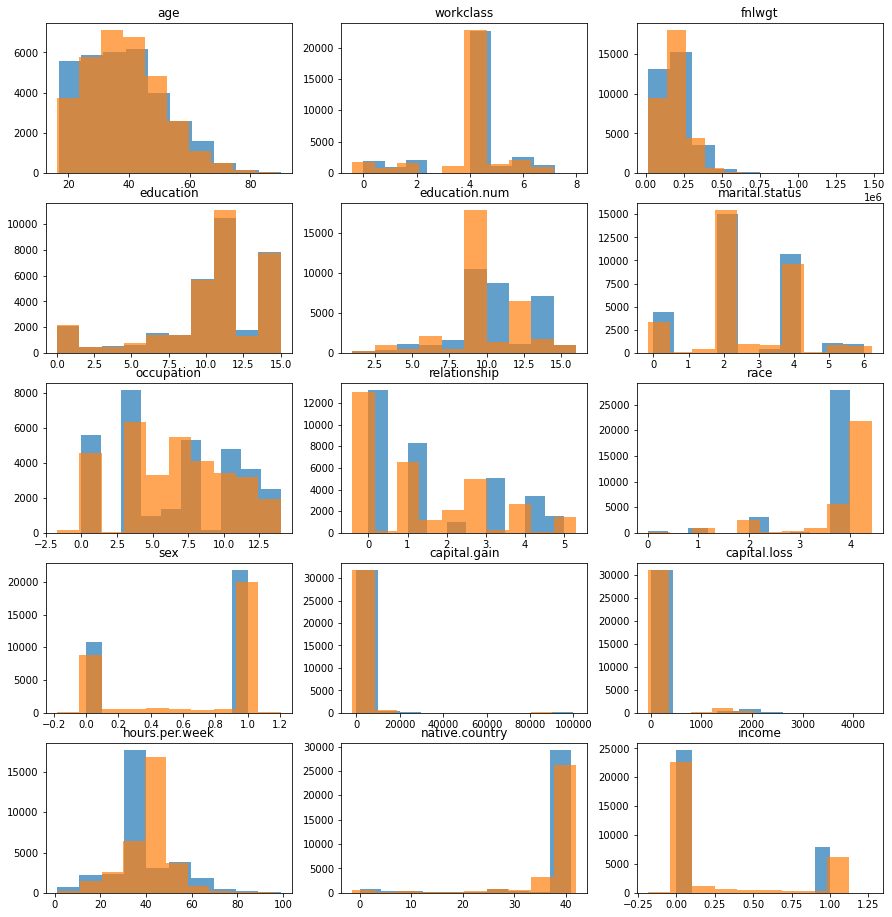

In [77]:
# Let's see how well our synthetic data captured the statistical relationship 
fig, ax = plt.subplots(figsize=(15, 16), nrows=5, ncols=3)
ax = ax.flatten()
for i, c in enumerate(df.columns):
    ax[i].hist(df[c], alpha=.7)
    ax[i].hist(syn[c], alpha=.7)
    ax[i].title.set_text(c)

## SyntheticForest vs SMOTE  

In [67]:
import math

def hellinger_explicit(p, q):
    """Hellinger distance between two discrete distributions.
       Same as original version but without list comprehension
    """
    list_of_squares = []
    for p_i, q_i in zip(p, q):

        # caluclate the square of the difference of ith distr elements
        s = (math.sqrt(p_i) - math.sqrt(q_i)) ** 2

        # append 
        list_of_squares.append(s)

    # calculate sum of squares
    sosq = sum(list_of_squares)    

    return sosq / math.sqrt(2)

In [83]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
syn2 = pd.DataFrame(scaler.fit_transform(syn), columns=syn.columns)
df2 = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

In [85]:
for c in ['workclass', 'education', 'marital.status', 'occupation', 'relationship', 'race', 'sex', 'native.country', 'income']:
    h = hellinger_explicit(syn2[c], df2[c])
    print(f"Hellinger Distance of {c}: {h}")

Hellinger Distance of workclass: 1371.7505360187552
Hellinger Distance of education: 2150.8459389619893
Hellinger Distance of marital.status: 2609.9248712198782
Hellinger Distance of occupation: 2510.7397486676214
Hellinger Distance of relationship: 4692.491681349531
Hellinger Distance of race: 970.8058684679423
Hellinger Distance of sex: 6637.734021804208
Hellinger Distance of native.country: 985.5634465274912
Hellinger Distance of income: 6831.792193257145


In [90]:
for c in ['age', 'fnlwgt', 'education.num', 'capital.gain', 'capital.loss', 'hours.per.week']:
    mae = abs(syn2[c] - df2[c]).mean()
    print(f"MAE of {c}: {mae}")

MAE of age: 0.02488250163619551
MAE of fnlwgt: 0.01864624865251963
MAE of education.num: 1.3600905870932545e-06
MAE of capital.gain: 0.018415568034300896
MAE of capital.loss: 0.01968183266229539
MAE of hours.per.week: 0.01648460131161062


In [92]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
df_smote = sm.fit_resample(df.drop('income', axis=1), df['income'])

In [102]:
df_smote = pd.concat([df_smote[0], df_smote[1]], axis=1)

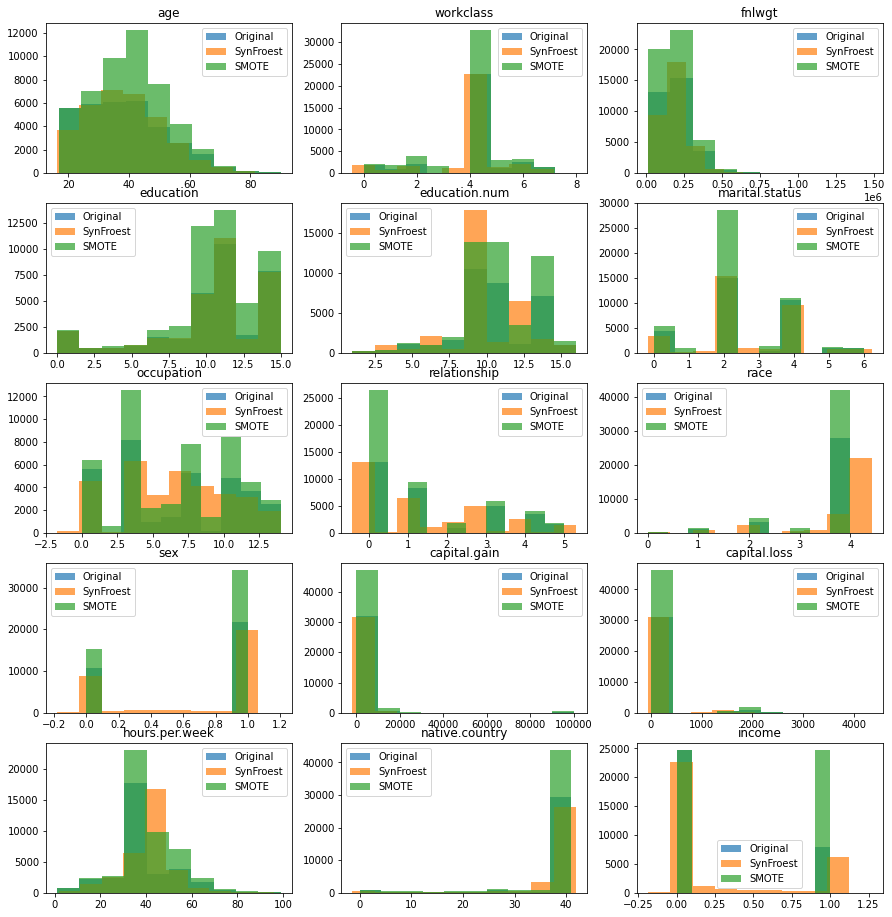

In [104]:
fig, ax = plt.subplots(figsize=(15, 16), nrows=5, ncols=3)
ax = ax.flatten()
for i, c in enumerate(df.columns):
    ax[i].hist(df[c], alpha=.7)
    ax[i].hist(syn[c], alpha=.7)
    ax[i].hist(df_smote[c], alpha=.7)
    ax[i].title.set_text(c)
    ax[i].legend(['Original', 'SynFroest', 'SMOTE'])

In [105]:
for c in ['workclass', 'education', 'marital.status', 'occupation', 'relationship', 'race', 'sex', 'native.country', 'income']:
    h = hellinger_explicit(syn2[c], df_smote[c])
    print(f"Hellinger Distance of {c}: {h}")

Hellinger Distance of workclass: 39975.40641185558
Hellinger Distance of education: 138853.20226301719
Hellinger Distance of marital.status: 27497.95206291088
Hellinger Distance of occupation: 87011.568143316
Hellinger Distance of relationship: 19659.826827742243
Hellinger Distance of race: 25054.88486535234
Hellinger Distance of sex: 6637.734021804208
Hellinger Distance of native.country: 610362.8950684217
Hellinger Distance of income: 6831.792193257145


In [106]:
for c in ['age', 'fnlwgt', 'education.num', 'capital.gain', 'capital.loss', 'hours.per.week']:
    mae = abs(syn2[c] - df_smote[c]).mean()
    print(f"MAE of {c}: {mae}")

MAE of age: 38.27351682315878
MAE of fnlwgt: 189778.22751205557
MAE of education.num: 9.475302077718013
MAE of capital.gain: 1077.6553162024961
MAE of capital.loss: 87.30344183895444
MAE of hours.per.week: 40.02681936109971
